# Timeseries classification 


## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [3]:

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


x_train, y_train = readucr( "FordA_TRAIN.tsv")
x_test, y_test = readucr( "FordA_TEST.tsv")

## Visualize 

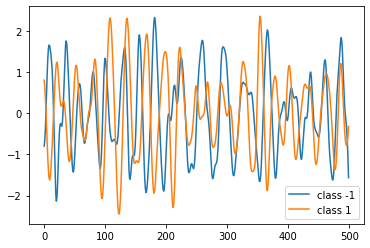

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

In [5]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [6]:
num_classes = len(np.unique(y_train))

In [7]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [8]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

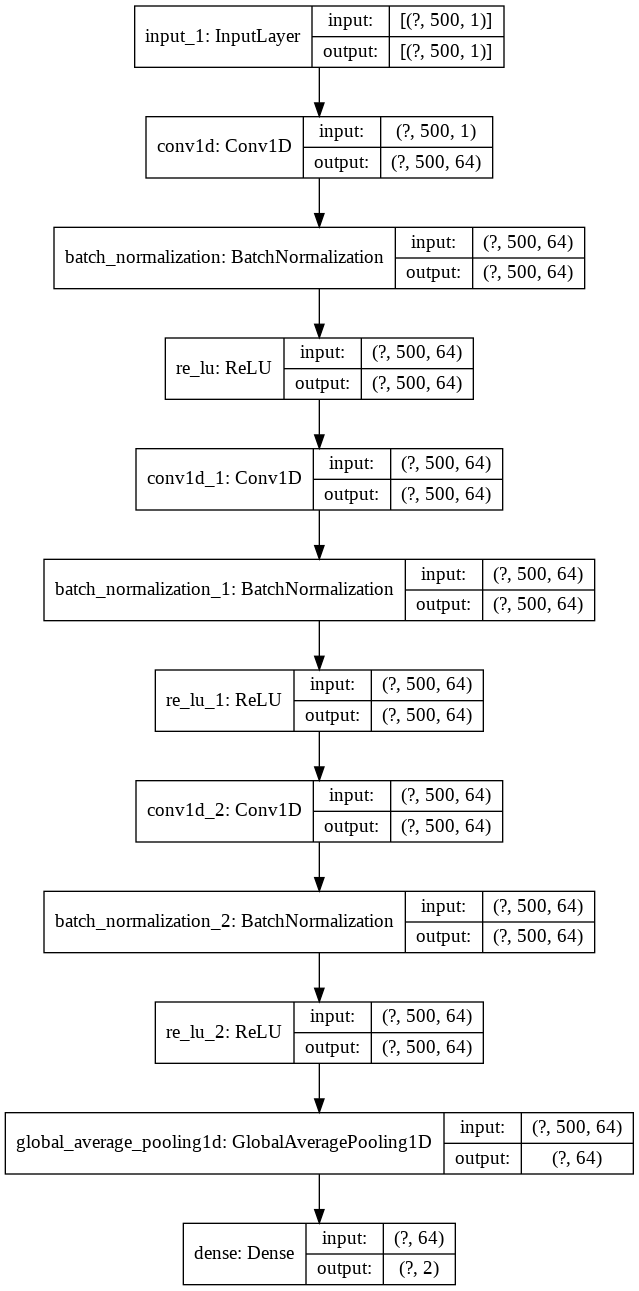

In [9]:

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [10]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.7525 - val_sparse_categorical_accuracy: 0.4632
Epoch 2/500
90/90 [==============================] - 0s 6ms/step - loss: 0.4773 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.7844 - val_sparse_categorical_accuracy: 0.4632
Epoch 3/500
90/90 [==============================] - 1s 6ms/step - loss: 0.4538 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.4632
Epoch 4/500
90/90 [==============================] - 1s 6ms/step - loss: 0.4339 - sparse_categorical_accuracy: 0.7747 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.4868
Epoch 5/500
90/90 [==============================] - 1s 6ms/step - loss: 0.4151 - sparse_categorical_accuracy: 0.7958 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6338
Epoch 6/500
90/90 [==============================] - 1s 6ms/step - loss: 0.4213 - sparse_categorical_accu

## Evaluate model on test data

In [12]:
model = keras.models.load_model("class_best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 3ms/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9667
Test accuracy 0.9666666388511658
Test loss 0.09650245308876038


## Plot the model's training and validation loss

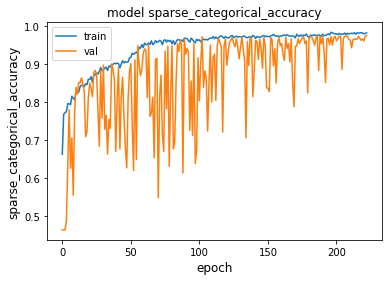

In [13]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

The training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.